In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import STL10
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
from utils import*
# Import necessary packages
import litdata

import torchvision.transforms as T

source_folder = 'source'

# Set seed
seed = 1

In [3]:
import litdata
from torch import nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
batch_size =  128
# Define mean and std from ImageNet data
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

class ToRGBTensor:
    
    def __call__(self, img):
        return F.to_tensor(img).expand(3, -1, -1) # Expand to 3 channels
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
#Loads in data and returns the dataloader

    
datapath = '/projects/ec232/data/'

# Define postprocessing / transform of data modalities
postprocess = (
    T.Compose([                        # Handles processing of the .jpg image
    ToRGBTensor(), 
    T.Resize((224,224), antialias=None),# Convert from PIL image to RGB torch.Tensor.
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize image to correct mean/std.
]),
nn.Identity(), 
)

# Load training and validation data
traindata = litdata.LITDataset('ImageWoof', datapath).map_tuple(*postprocess)
valdata = litdata.LITDataset('ImageWoof', datapath, train=False).map_tuple(*postprocess)

# Make and return the dataloaders
train_dataloader = DataLoader(traindata, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(valdata, shuffle=False, batch_size=batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input size images torch.Size([224, 224, 3])


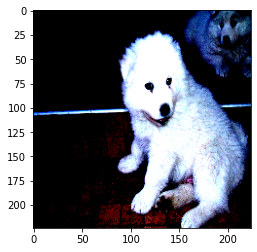

In [5]:

" Visualization of dataset"
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

image_data = np.transpose(images[4], (1, 2, 0))

plt.imshow(image_data)
print("input size images",image_data.shape)


In [6]:
num_classes = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ViT model with pretrained weighs
model_lora = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes).to(device)

In [14]:

import torch
from PIL import Image
import torchvision.transforms as transforms

class CustomViTFeatureExtractor:
    def __init__(self, image_size=192, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.image_size = image_size
        self.mean = mean
        self.std = std
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image_path):
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Add batch dimension
        #image = image.unsqueeze(0)

        return image

# Usage example:
image_path = '/fp/projects01/ec232/g01/g01-p1/data/imagewoof2/val/n02099601/n02099601_101.JPEG'
custom_feature_extractor = CustomViTFeatureExtractor()
image = custom_feature_extractor(image_path)

# Print the shape of the image tensor
print(image.shape)  # Output




torch.Size([3, 192, 192])


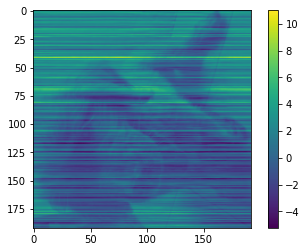

In [18]:

import torch
import matplotlib.pyplot as plt



# Assuming you have your ViT model loaded as 'model_lora'
# and you have an image tensor 'image' with shape [batch_size, channels, height, width]

# Forward pass through the last layer of the ViT model
with torch.no_grad():
    # Get the output of the last layer (block 11 in your case)
    last_layer_output = model_lora.blocks[11](image)

# Assuming 'last_layer_output' is of shape [batch_size, num_tokens, hidden_size]
# where 'num_tokens' is the number of patches or tokens and 'hidden_size' is the dimension of the hidden states

# Reshape the output to [batch_size, num_tokens, num_tokens, num_heads]
attention_maps = last_layer_output.permute( 0, 2, 1)

# Visualize the attention map for the first example in the batch and the first attention head
plt.imshow(attention_maps[2, :, :].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.show()


